In [1]:
#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as pl
%matplotlib inline
import imageio
from scipy.interpolate import interp1d

#Edge Detection
import skimage
import skimage.feature
import skimage.viewer
import sys
from skimage.data import camera
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h

/anaconda3/lib/python2.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


**Step One: Edge Detection**

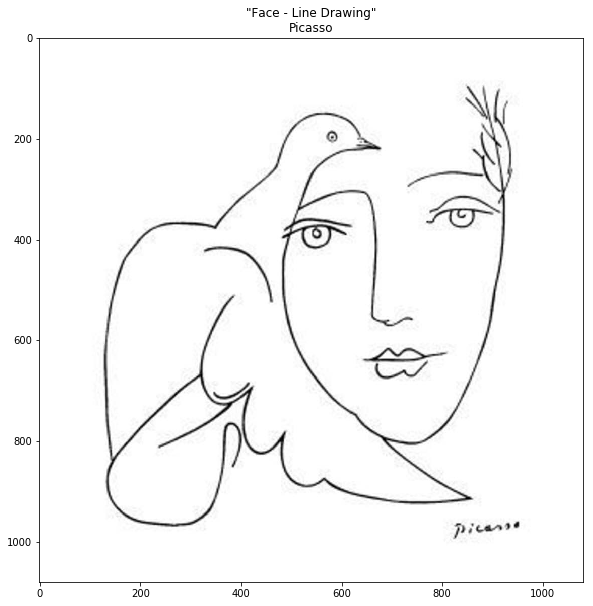

In [2]:
face = imageio.imread('Paintings/Face_Picasso.jpg')
plt.figure(figsize = (10,10))
plt.title('"Face - Line Drawing"\nPicasso')
plt.imshow(face)

In [3]:
#Ok, let's convert the grayscale to a simple black-white: that may help us in observing the 
#"Fractal" structure (and other formal qualities)

def bw_convert(img,thresh):
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    
    return bw_pic

#Ok, let's write a formula that can convert from color to bw/binary image
def make_bw(img,thresh=130):
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

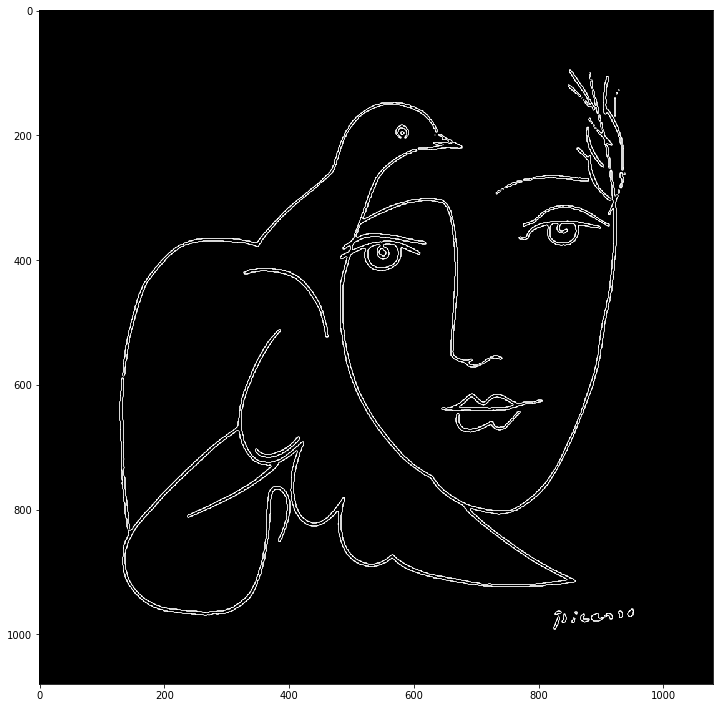

In [4]:
bw_face = make_bw(face,130)
face_edge = scharr(bw_face)
plt.figure(figsize = (10,10))
plt.imshow(face_edge, cmap=plt.cm.gray)
plt.tight_layout()
plt.show()

Now that we have an edge detector, let's write a formula that can decompose this matrix into two vectors: the x values and y values of all non-zero points.

In [5]:
def line_vectors(edge_image):
    row_vals = []
    col_vals = []
    for i in range(len(edge_image)):
        for j in range(len(edge_image[i])):
            if edge_image[i][j]>0:
                row_vals.append(i)
                col_vals.append(j)
    
    return list(reversed(col_vals)),row_vals

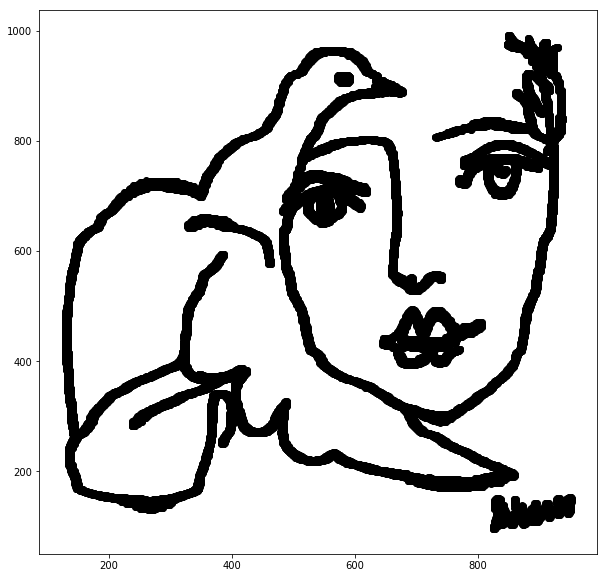

In [6]:
x_vals, y_vals = line_vectors(face_edge)
plt.figure(figsize = (10,10))
plt.scatter(x_vals,y_vals,color='k')
plt.show()

Now, let's create a whole new vector - this one a list of index values, such that every x/y pair will have a unique index value.

In [7]:
index_vals = []
index_val = 0
for i in x_vals:
    index_vals.append(index_val)
    index_val += 1
    
#And let's stitch this all up into a single dataframe
val_df = pd.DataFrame({
    'index':index_vals,
    'x_vals':x_vals,
    'y_vals':y_vals})

What do the above arrays look like, plotted relative to the index array?

Text(0.5,1,'X Values vs. Index')

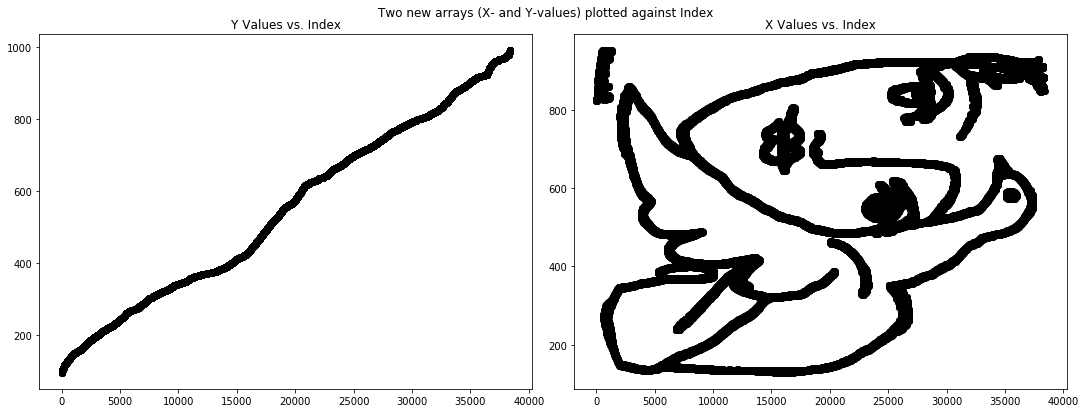

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new arrays (X- and Y-values) plotted against Index")

ax1.scatter(index_vals,y_vals,color='k')
ax1.set_title("Y Values vs. Index")
ax2.scatter(index_vals,x_vals,color='k')
ax2.set_title("X Values vs. Index")

Decomposing each image into a vector of xs and ys results in two arrays, each of each has no duplicate x/y pairs. While it's hard to tell from this image, the "X-Values" image on the right actually consists of lots of little dots/lines of dots, each of which is unique to each index value: there is only one Y-value (or in this case "X-value") for every index value. 

This obviates the problem we had before: of how to interplolate an image with multiple y values for every x value. 

We can now begin interpolating. What we will do is create a series of interpolating functions for the index/y pairs, and another set of interpolating functions for the index/x pairs. We will then plot these two sets of interpolating functions against each other. 

**Interpolation**

Our first step in interpolating will be to break up all of the little continuous line segments in the image on the right above (of X-Values plotted against Index) into discrete segments which we can then interpolate separately. 

In [9]:
def array_break(orig_array,thresh=2):
    index_arrays = []
    index_array = [0]
    ind = 0

    sub_arrays = []
    sub_array = [orig_array[0]]
    for i in orig_array[1:len(orig_array)]:
        ind += 1
        if np.abs(i - sub_array[-1])<3: ####
            sub_array.append(i)
            index_array.append(ind)

        else: 
            if len(sub_array)>thresh: #This is somewhat arbitrary: we just ignore sub-arrays that are smaller than the 
                #...abitrary threshold value; this reduces the complexity somewhat
                sub_arrays.append(sub_array)
                index_arrays.append(index_array)

                sub_array = []
                sub_array.append(i)

                index_array = []
                index_array.append(ind)
            else: #I.e., if the array is shorter than 2, then don't bother adding it
                sub_array = []
                sub_array.append(i)

                index_array = []
                index_array.append(ind)
                
    if len(sub_arrays)<1: ###
        return [index_array],[sub_array] ###
    else:
        return index_arrays,sub_arrays
    

In [10]:
def gen_interp_funs(index_arrays,sub_arrays):
    interp_funs = [] #This will be an array of separate interpolation functions
    for i in range(len(sub_arrays)):
        if len(sub_arrays[i])<4: #i.e., if the array is smaller than 3, just use linear interpolation
            f_i = interp1d(index_arrays[i], sub_arrays[i],fill_value="extrapolate")
            interp_funs.append(f_i)

        else:
            f_i = interp1d(index_arrays[i], sub_arrays[i], kind='cubic',fill_value="extrapolate")
            interp_funs.append(f_i)
    
    return interp_funs

In [11]:
def gen_interp_vals(interp_funs,index_arrays):
    calc_vals = []
    for i in range(len(index_arrays)):
        fun_iter = interp_funs[i]
        calc_val_list = [fun_iter(index_arrays[i])]
        calc_vals.append(calc_val_list)

    #Now let's stitch this all up into a single array
    calc_val_array = []
    for i in calc_vals:
        for j in i[0]:
            calc_val_array.append(j)

    index_val_array = []
    for i in index_arrays:
        for j in i:
            index_val_array.append(j)
    
    return index_val_array,calc_val_array

Now let's write a single function to automate the entire process: input a line image, and get back values of x's, y's, and interpolating functions for each. 

In [12]:
def interp_image(img):
    bw_img = make_bw(img,130)
    img_edge = scharr(bw_img)
    x_vals, y_vals = line_vectors(img_edge)
    
    index_vals = []
    index_val = 0
    for i in x_vals:
        index_vals.append(index_val)
        index_val += 1
    
    index_arrays,sub_arrays = array_break(x_vals)
    interp_funs = gen_interp_funs(index_arrays,sub_arrays)
    x_inds,xs = gen_interp_vals(interp_funs,index_arrays)
    
    index_arrays,sub_arrays = array_break(y_vals)
    interp_funs = gen_interp_funs(index_arrays,sub_arrays)
    y_inds,ys = gen_interp_vals(interp_funs,index_arrays)
    
    #Now let's filter to get the same indexed values of x and y
    ###IMPORTANT FILTERING STEP###
    #Getting rid of values that are unique to either array
    ####Should this be above? Perhaps in array break?####
    
    x_df = pd.DataFrame({
        'x_inds':x_inds,
        'x_vals':xs})

    y_df = pd.DataFrame({
            'y_inds':y_inds,
            'y_vals':ys})

    common_inds = np.intersect1d(x_inds,y_inds)

    x_array = np.array(x_df)
    y_array = np.array(y_df)

    filtered_x_vals = []
    for i in x_array:
        if i[0] in common_inds:
            filtered_x_vals.append(i[1])

    filtered_y_vals = []
    for i in y_array:
        if i[0] in common_inds:
            filtered_y_vals.append(i[1])
    
    return filtered_x_vals,filtered_y_vals

In [13]:
xs,ys = interp_image(face)

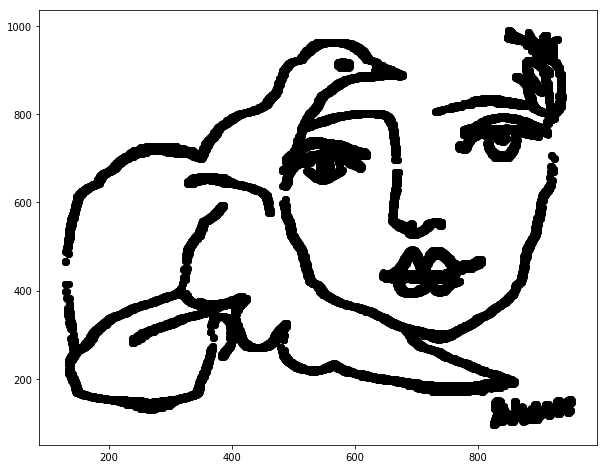

In [14]:
xs,ys = interp_image(face)
plt.figure(figsize = (10,8))
plt.scatter(xs,ys,color='k')
plt.show()

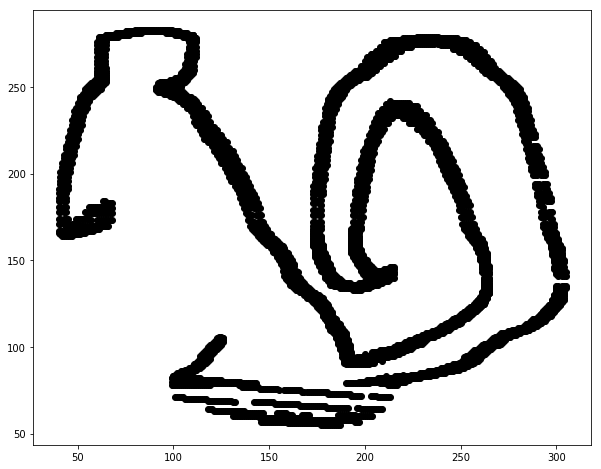

In [15]:
squirrel = imageio.imread('Paintings/Squirrel_Picasso.jpg')
plt.figure(figsize = (10,8))
xs,ys = interp_image(squirrel)
plt.scatter(xs,ys,color='k')
plt.show()

It works! On an unseen image! Amazing!

**Optimization**

Let's write an algorithm with some randomness in it that can link our values together in various continuous ways.

Do it stochastically.....it will choose a random next one that is within space 1 of the current cell. You can start the search in a range of different places, and choose the one that finds the lowest number of interpolating functions. 

It will start anew when it reaches a dead end/runs out of "next ones" to add to the series. 

In [16]:
val_array = np.array(val_df)
orig_val_array = np.copy(val_array)

In [17]:
def reorder(input_array):
    
    val_array = np.copy(input_array)
    new_val_order = []
    start_points = val_array[np.random.randint(len(val_array))]
    val_array = val_array[val_array[:,0] != start_points[0]] #Remove the (random) starting value from val_array

    new_val_order.append(start_points)

    while len(val_array)>0:    
        prev_val = new_val_order[-1]
        prev_val_1 = prev_val[1]
        prev_val_2 = prev_val[2]

        filtering_array = val_array[(val_array[:,1] >= prev_val_1 - 1) & (val_array[:,1] <= prev_val_1 + 1)]
        filtering_array = filtering_array[(filtering_array[:,2] >= prev_val_2 - 1) & (filtering_array[:,2] <= prev_val_2 + 1)]

        if len(filtering_array)>0:
            choice_index = np.random.choice(range(len(filtering_array)))
            item_add = filtering_array[choice_index]
            new_val_order.append(item_add)

            val_array = val_array[val_array[:,0] != item_add[0]] #This updates the master array to remove the item we added

        else:
            start_points = val_array[np.random.randint(len(val_array))] #Or else, start with a new random value from val_array
            val_array = val_array[val_array[:,0] != start_points[0]]
            new_val_order.append(start_points)
            
    x_vals = []
    y_vals = []
    new_index = []
    j = 0
    for i in new_val_order:
        x_vals.append(i[1])
        y_vals.append(i[2])
        new_index.append(j)
        j += 1
        
    #And let's stitch this all up into a single dataframe
    new_df = pd.DataFrame({
        'index':new_index,
        'x_vals':x_vals,
        'y_vals':y_vals})
            
    return new_df,x_vals,y_vals


In [18]:
new_df,x_vals,y_vals = reorder(val_array)

In [19]:
x_ind,x_subs = array_break(x_vals,thresh=2)

In [20]:
y_ind,y_subs = array_break(y_vals,thresh=2)

In [21]:
def get_min_interps(val_array,iters=10):
    
    new_dfs = []
    x_interps = []
    y_interps = []
    total_interps = []
    
    x_arrays = []
    y_arrays = []
    
    for i in range(iters):
        new_df,x_vals,y_vals = reorder(val_array)
        new_dfs.append(new_df)
        
        x_index_arrays,x_sub_arrays = array_break(x_vals)
        y_index_arrays,y_sub_arrays = array_break(y_vals)
        
        len_x = len(x_sub_arrays)
        len_y = len(y_sub_arrays)
        len_total = len_x + len_y
        
        x_interps.append(len_x)
        y_interps.append(len_y)
        total_interps.append(len_total)
        
        x_arrays.append(x_sub_arrays)
        y_arrays.append(y_sub_arrays)
    
    return [new_dfs,x_interps,y_interps,total_interps,x_index_arrays,y_index_arrays,x_arrays,y_arrays]

In [22]:
interp_output = get_min_interps(val_array,iters=20)

Text(0.5,1,'Y Values vs. Index')

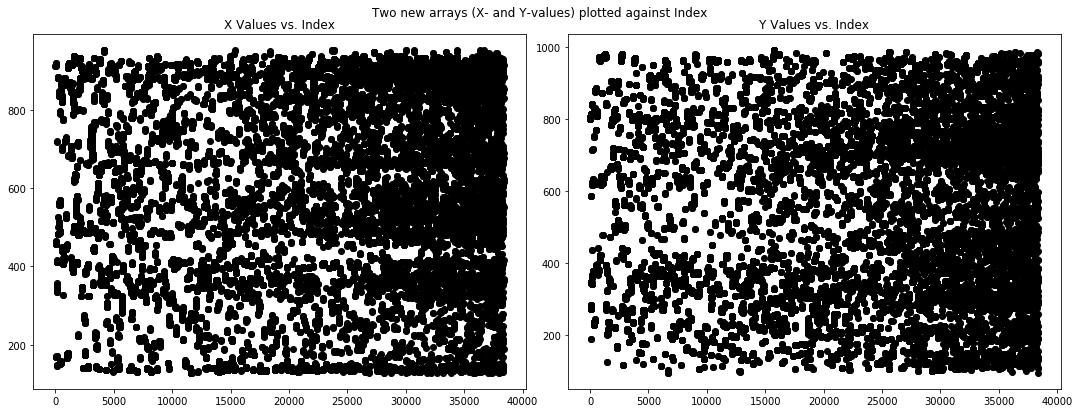

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new arrays (X- and Y-values) plotted against Index")

ax1.scatter(interp_output[0][0]['index'],interp_output[0][0]['x_vals'],color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(interp_output[0][0]['index'],interp_output[0][0]['y_vals'],color='k')
ax2.set_title("Y Values vs. Index")

Ok, so evidently our optimizer doesn't work so well. 

Within each of these random searches, what is the largest chunk of continuous x/y values?

In [24]:
#The below retrieves the maximum arrays for every iteration
max_y_len = []
max_y_index = []
for i in interp_output[-1]:
    y_chunk_lens = []
    for j in i:
        y_chunk_lens.append(len(j))
    max_y_len.append(np.max(y_chunk_lens))
    max_y_index.append(np.argmax(y_chunk_lens))
    

max_x_len = []
max_x_index = []
for i in interp_output[-2]:
    x_chunk_lens = []
    for j in i:
        x_chunk_lens.append(len(j))
    max_x_len.append(np.max(x_chunk_lens))
    max_x_index.append(np.argmax(x_chunk_lens))

In [25]:
opt_index = np.argmax(max_y_len)
overall_opt = max_y_index[opt_index]

x_opt = interp_output[-2][opt_index][overall_opt]
y_opt = interp_output[-1][opt_index][overall_opt]

In [26]:
opt_x_vals = []
opt_y_vals = []

for i in range(len(max_y_len)):
    x_opt = interp_output[-2][i][max_x_index[i]]
    y_opt = interp_output[-1][i][max_y_index[i]]
    
    opt_x_vals.append(x_opt)
    opt_y_vals.append(y_opt)

(0, 50)

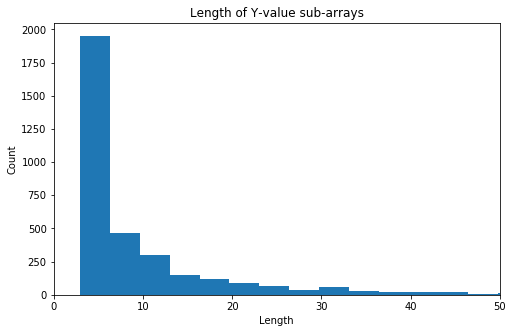

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(y_chunk_lens,bins=50)
ax.set_xlabel('Length')
ax.set_ylabel('Count')
ax.set_title('Length of Y-value sub-arrays')
ax.set_xlim([0,50])

Hmmm, ok....maybe we could write something to run the above a large number of times, collect all of the arrays that lie above a threshhold (say, 100) and then just use those?

In [28]:
list1, list2 = zip(*sorted(zip(x_vals, y_vals)))

In [29]:
index_vals = []
index_val = 0
for i in list1:
    index_vals.append(index_val)
    index_val += 1
    
#And let's stitch this all up into a single dataframe
val_df = pd.DataFrame({
    'index':index_vals,
    'x_vals':list1,
    'y_vals':list2})

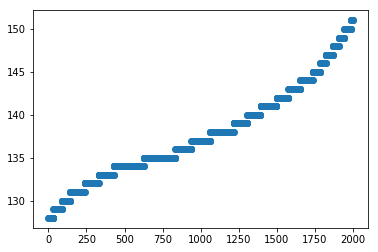

In [30]:
plt.scatter(val_df[0:2000]['index'],val_df[0:2000]['x_vals'])

From this we see that there are a lot of repeat values. That's a bit of a waste really....It would be better if we somehow sorted it to oscillate in some way. 

**Sorting in Wave Form**

In [31]:
val_array = np.array(val_df)
orig_val_array = np.copy(val_array)

In [32]:
xmin = np.min(val_array[:,1])
xmax = np.max(val_array[:,1])

ymin = np.min(val_array[:,2])
ymax = np.max(val_array[:,2])

In [33]:
#Choosing random starting points: minimum x, minimum y, random choice within that
start_array = val_array[val_array[:,1] == xmin]
new_ymin = np.min(start_array[:,2])
start_array = start_array[start_array[:,2]==new_ymin]
start_points = start_array[np.random.randint(len(start_array))]

In [34]:
new_val_order = []
new_val_order.append(start_points)

prev_val = new_val_order[-1]
prev_val_1 = prev_val[1]
prev_val_2 = prev_val[2]

filtering_array = val_array[(val_array[:,1] > prev_val_1)]
filtering_array = filtering_array[(filtering_array[:,2] > prev_val_2)]

new_xmin = np.min(filtering_array[:,1])
filtering_array = filtering_array[filtering_array[:,1]==new_xmin]
new_ymin = np.min(filtering_array[:,2])
filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
next_points = filtering_array[np.random.randint(len(filtering_array))]



In [35]:
#From here, let's choose the next highest x value and the next highest y value. When there is no next highest value,
#we reverse direction

#We can probably do this with two While loops

In [36]:
def reorder_wave_form(input_array):
    
    val_array = np.copy(input_array)
    new_val_order = []
    
    xmin = np.min(val_array[:,1])
    xmax = np.max(val_array[:,1])
    ymin = np.min(val_array[:,2])
    ymax = np.max(val_array[:,2])
    
    #Choosing random starting points: minimum x, minimum y, random choice within that
    start_array = val_array[val_array[:,1] == xmin]
    new_ymin = np.min(start_array[:,2])
    start_array = start_array[start_array[:,2] == new_ymin]
    start_points = start_array[np.random.randint(len(start_array))]
    
    val_array = val_array[val_array[:,0] != start_points[0]] #Remove the (random) starting value from val_array
    new_val_order.append(start_points)
    
    #For now, let's just try to get one of the arrays to work in oscillating form, and for the other we'll just take the min value
    while len(val_array)>0:    
        prev_val = new_val_order[-1]
        prev_val_1 = prev_val[1]
        prev_val_2 = prev_val[2]
        
        x_max = np.max(val_array[:,1])
        x_min = np.min(val_array[:,1])
        
        while prev_val_1 < x_max:
            filtering_array = val_array[(val_array[:,1] > prev_val_1)]
            new_xmin = np.min(filtering_array[:,1])
            filtering_array = filtering_array[filtering_array[:,1]==new_xmin]
            new_ymin = np.min(filtering_array[:,2])
            filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
            next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
            
            new_val_order.append(next_points) #Append the next points to the new array
            val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            
            prev_val = new_val_order[-1]
            prev_val_1 = prev_val[1]
            prev_val_2 = prev_val[2]
            
            if prev_val_1 == x_max:
                x_min = np.min(val_array[:,1]) 
                while prev_val_1 > x_min:
                    filtering_array = val_array[(val_array[:,1] < prev_val_1)]
                    new_xmax = np.max(filtering_array[:,1])
                    filtering_array = filtering_array[filtering_array[:,1]==new_xmax]
                    
                    new_ymax = np.max(filtering_array[:,2]) 
                    filtering_array = filtering_array[filtering_array[:,2]==new_ymax] 
                    
                    next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points

                    new_val_order.append(next_points) #Append the next points to the new array
                    val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array

                    prev_val = new_val_order[-1]
                    prev_val_1 = prev_val[1]
                    prev_val_2 = prev_val[2]
                    
                    if prev_val_1 == x_min: 
                        x_max = np.max(val_array[:,1])
        
        #For now, let's just add the remaining values to the array
        for i in val_array:
            new_val_order.append(i)
            val_array = val_array[val_array[:,0] != i[0]] #Remove the item from val array
        
        
    x_vals = []
    y_vals = []
    new_index = []
    j = 0
    for i in new_val_order:
        x_vals.append(i[1])
        y_vals.append(i[2])
        new_index.append(j)
        j += 1
        
    #And let's stitch this all up into a single dataframe
    new_df = pd.DataFrame({
        'index':new_index,
        'x_vals':x_vals,
        'y_vals':y_vals})
            
    return new_df,x_vals,y_vals


In [37]:
new_df, new_x, new_y = reorder_wave_form(val_array)

Let's visualize the reordered arrays that have been created! 

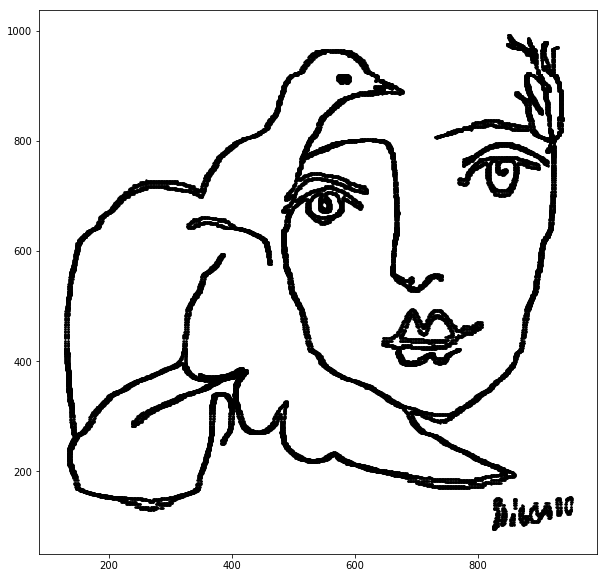

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(new_df['x_vals'],new_df['y_vals'],s=2,color='k')

Text(0.5,1,'Y Values vs. Index')

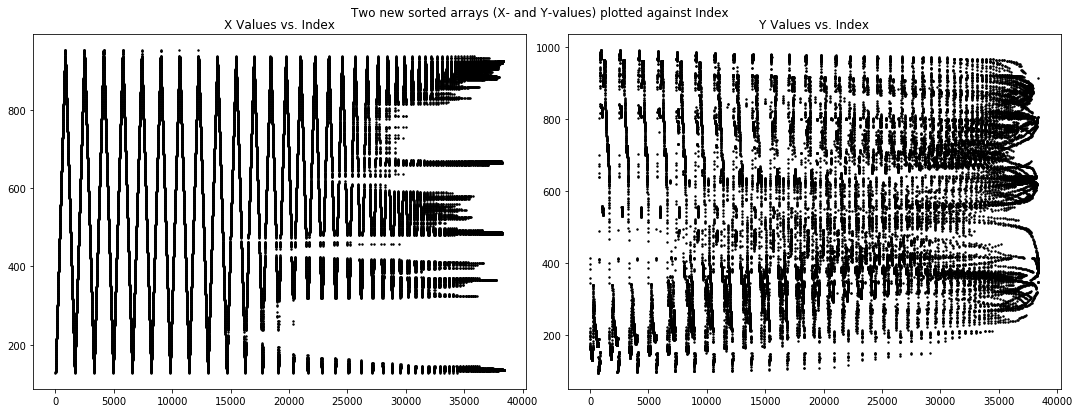

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new sorted arrays (X- and Y-values) plotted against Index")

ax1.scatter(new_df['index'],new_df['x_vals'],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(new_df['index'],new_df['y_vals'],s=2,color='k')
ax2.set_title("Y Values vs. Index")

Very cool! It definitely looks like each of these two arrays could be approximated by some sort of continuous/oscillating function. 

And if not a function, we could write some sort of rules that inform something how to print the above: in other words, you could approximate both x and y arrays with a single function for each. This would be a significant reduction in information. 

Further, we could probably be more orderly about how we add the y-values in our above loop. In the above, we just add the minimum/maximum y (depending on the direction the algorithm is adding x-values), which does not necessarily give rise to oscillating behavior. Would it be possible to impose similar oscillation rules to the way we add y-values?

For now, let's take a look at just the parts of these arrays that seem orderly and well-behaved: i.e. the first half or so. 

In [40]:
xy_array = np.array(new_df)
small_array = xy_array[0:20000]

Text(0.5,1,'Y Values vs. Index')

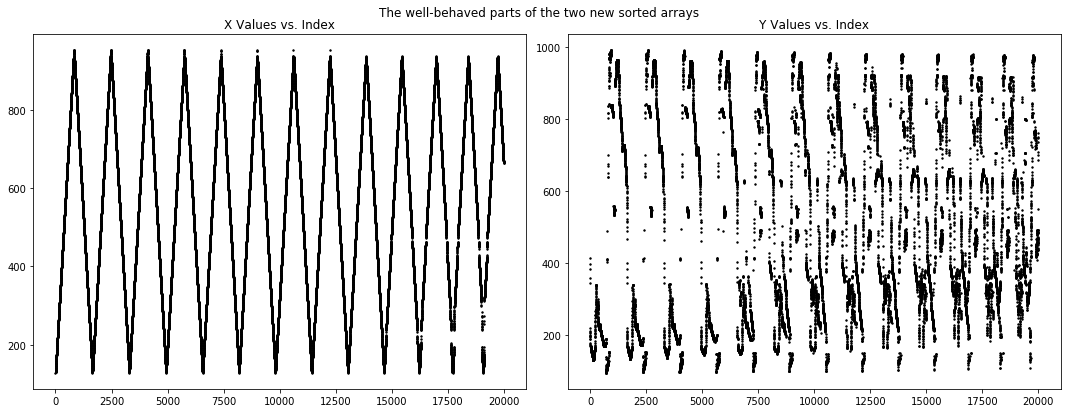

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("The well-behaved parts of the two new sorted arrays")

ax1.scatter(small_array[:,0],small_array[:,1],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(small_array[:,0],small_array[:,2],s=2,color='k')
ax2.set_title("Y Values vs. Index")

An even narrower view gives a sense of the oscillating pattern of the two arrays.

Text(0.5,1,'Y Values vs. Index')

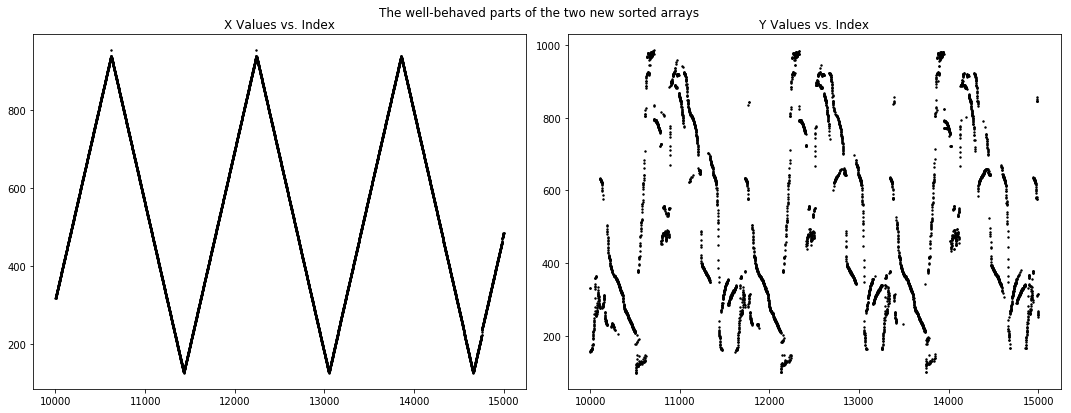

In [42]:
xy_array = np.array(new_df)
narrower_array = xy_array[10000:15000]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("The well-behaved parts of the two new sorted arrays")

ax1.scatter(narrower_array[:,0],narrower_array[:,1],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(narrower_array[:,0],narrower_array[:,2],s=2,color='k')
ax2.set_title("Y Values vs. Index")

What do these two, reduced portions look like plotted against one another?

Text(0.5,1,'Simplified Arrays plotted against one another')

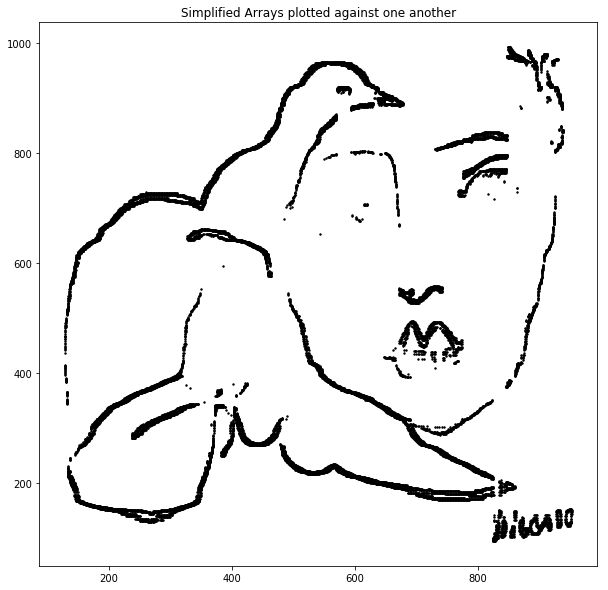

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(small_array[:,1],small_array[:,2],s=2,color='k')
ax.set_title("Simplified Arrays plotted against one another")

Text(0.5,1,'Simplified Arrays plotted against one another')

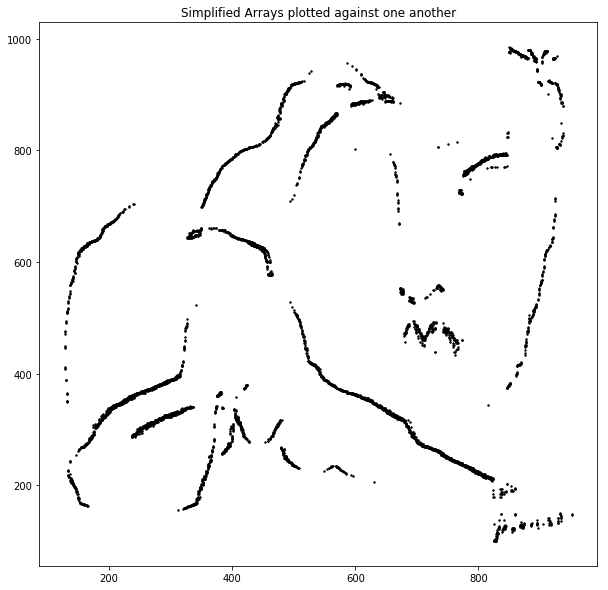

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(narrower_array[:,1],narrower_array[:,2],s=2,color='k')
ax.set_title("Simplified Arrays plotted against one another")

Wow! What we see is a reduced/simplified version of the master image. 

In [45]:
yx_array = xy_array.copy()
yx_array[:,1] = xy_array[:,2]
yx_array[:,2] = xy_array[:,1]

In [46]:
new_df_2, new_x_2, new_y_2 = reorder_wave_form(yx_array)

Text(0.5,1,'Y Values vs. Index')

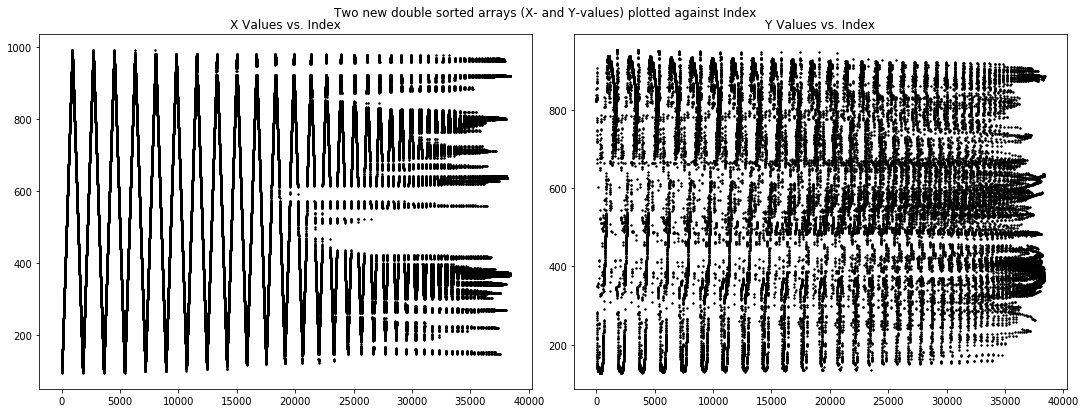

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new double sorted arrays (X- and Y-values) plotted against Index")

ax1.scatter(new_df_2['index'],new_df_2['x_vals'],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(new_df_2['index'],new_df_2['y_vals'],s=2,color='k')
ax2.set_title("Y Values vs. Index")

In [75]:
yx_array_2 = np.array(new_df_2)
small_array_2 = yx_array_2[0:12000]

Text(0.5,1,'Y Values vs. Index')

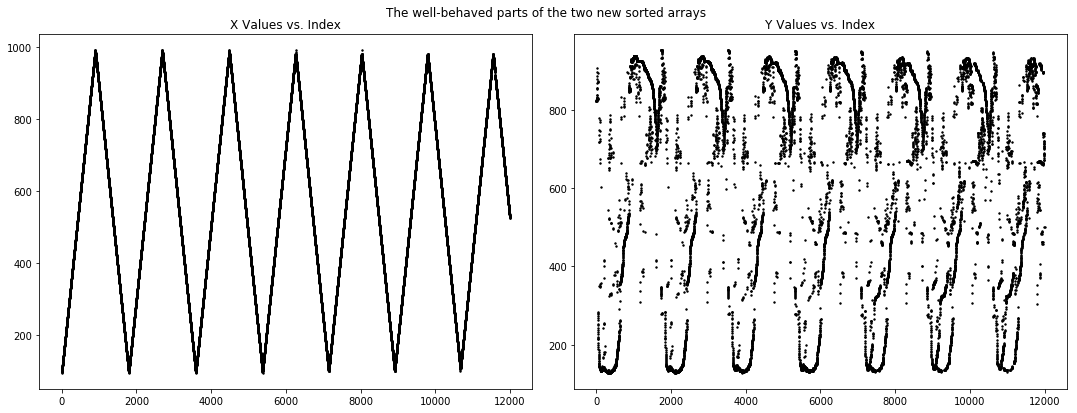

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("The well-behaved parts of the two new sorted arrays")

ax1.scatter(small_array_2[:,0],small_array_2[:,1],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(small_array_2[:,0],small_array_2[:,2],s=2,color='k')
ax2.set_title("Y Values vs. Index")

Text(0.5,1,'Simplified Arrays plotted against one another')

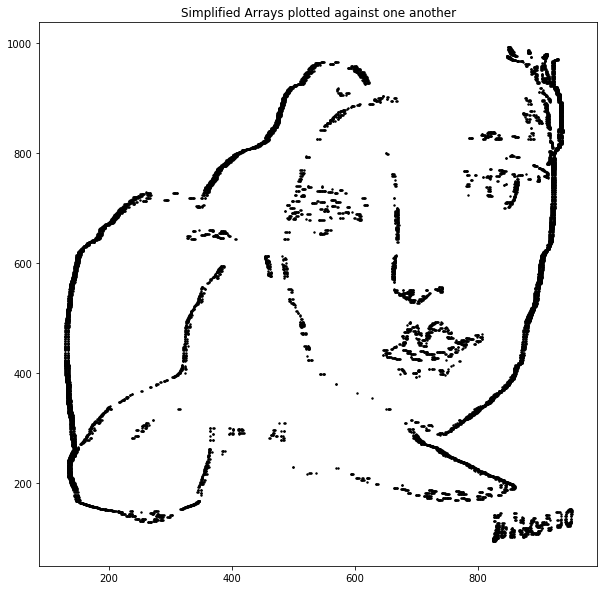

In [79]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(small_array_2[:,2],small_array_2[:,1],s=2,color='k')
ax.set_title("Simplified Arrays plotted against one another")

Can we write a double wave-form function?

In [50]:
def double_wave_form(input_array):
    
    val_array = np.copy(input_array)
    new_val_order = []
    
    xmin = np.min(val_array[:,1])
    xmax = np.max(val_array[:,1])
    ymin = np.min(val_array[:,2])
    ymax = np.max(val_array[:,2])
    
    #Choosing random starting points: minimum x, minimum y, random choice within that
    start_array = val_array[val_array[:,1] == xmin]
    new_ymin = np.min(start_array[:,2])
    start_array = start_array[start_array[:,2] == new_ymin]
    start_points = start_array[np.random.randint(len(start_array))]
    
    val_array = val_array[val_array[:,0] != start_points[0]] #Remove the (random) starting value from val_array
    new_val_order.append(start_points)
    
    #We have to initialize this more: get two starting values, so that our algorithm can tell the direction we're going
    prev_val = new_val_order[-1]
    prev_val_1 = prev_val[1]
    prev_val_2 = prev_val[2]
    
    filtering_array = val_array[(val_array[:,1] > prev_val_1)]
    new_xmin = np.min(filtering_array[:,1])
    filtering_array = filtering_array[filtering_array[:,1]==new_xmin]
    
    if np.min(filtering_array[:,2]) >= prev_val_2:
        new_ymin = np.min(filtering_array[:,2])
        filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
        next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
        new_val_order.append(next_points) #Append the next points to the new array
        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        prev_val = new_val_order[-1]
        prev_val_1 = prev_val[1]
        prev_val_2 = prev_val[2]
    
    else:
        new_ymax = np.max(filtering_array[:,2])
        filtering_array = filtering_array[filtering_array[:,2]==new_ymax]
        next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
        new_val_order.append(next_points) #Append the next points to the new array
        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        prev_val = new_val_order[-1]
        prev_val_1 = prev_val[1]
        prev_val_2 = prev_val[2]
    
    #For now, let's just try to get one of the arrays to work in oscillating form, and for the other we'll just take the min value
    while len(val_array)>0:    
        prev_val = new_val_order[-1]
        prev2_val = new_val_order[-2]
        
        prev_val_1 = prev_val[1]
        prev_val_2 = prev_val[2]
        prev2_val_2 = prev2_val[2]

        x_max = np.max(val_array[:,1])
        x_min = np.min(val_array[:,1])
        y_max = np.max(val_array[:,2])
        y_min = np.min(val_array[:,2])
        
        while prev_val_1 < x_max:
            filtering_array = val_array[(val_array[:,1] > prev_val_1)]
            new_xmin = np.min(filtering_array[:,1])
            filtering_array = filtering_array[filtering_array[:,1]==new_xmin]
            
            if prev_val_2 == y_max:
                new_ymax = np.max(filtering_array[:,2])
                filtering_array = filtering_array[filtering_array[:,2]==new_ymax]
                next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                prev_val = new_val_order[-1]
                prev2_val = new_val_order[-2]
                prev_val_1 = prev_val[1]
                prev_val_2 = prev_val[2]
                prev2_val_2 = prev2_val[2]
                
            if prev_val_2 == y_min:
                new_ymin = np.min(filtering_array[:,2])
                filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
                next_points = filtering_array[np.random.randint(len(filtering_array))]
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                prev_val = new_val_order[-1]
                prev2_val = new_val_order[-2]
                prev_val_1 = prev_val[1]
                prev_val_2 = prev_val[2]
                prev2_val_2 = prev2_val[2]
            
            if prev_val_2 > prev2_val_2:
                new_ymin = np.min(filtering_array[:,2])
                filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
                next_points = filtering_array[np.random.randint(len(filtering_array))]
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                prev_val = new_val_order[-1]
                prev2_val = new_val_order[-2]
                prev_val_1 = prev_val[1]
                prev_val_2 = prev_val[2]
                prev2_val_2 = prev2_val[2]
                
            else:
                new_ymax = np.max(filtering_array[:,2])
                filtering_array = filtering_array[filtering_array[:,2]==new_ymax]
                next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                prev_val = new_val_order[-1]
                prev2_val = new_val_order[-2]
                prev_val_1 = prev_val[1]
                prev_val_2 = prev_val[2]
                prev2_val_2 = prev2_val[2]
            
            if prev_val_1 == x_max:
                x_min = np.min(val_array[:,1]) 
                while prev_val_1 > x_min:
                    filtering_array = val_array[(val_array[:,1] < prev_val_1)]
                    new_xmax = np.max(filtering_array[:,1])
                    filtering_array = filtering_array[filtering_array[:,1]==new_xmax]
                    
                    if prev_val_2 == y_max:
                        new_ymax = np.max(filtering_array[:,2])
                        filtering_array = filtering_array[filtering_array[:,2]==new_ymax]
                        next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
                        new_val_order.append(next_points) #Append the next points to the new array
                        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                        prev_val = new_val_order[-1]
                        prev2_val = new_val_order[-2]
                        prev_val_1 = prev_val[1]
                        prev_val_2 = prev_val[2]
                        prev2_val_2 = prev2_val[2]

                    if prev_val_2 == y_min:
                        new_ymin = np.min(filtering_array[:,2])
                        filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
                        next_points = filtering_array[np.random.randint(len(filtering_array))]
                        new_val_order.append(next_points) #Append the next points to the new array
                        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                        prev_val = new_val_order[-1]
                        prev2_val = new_val_order[-2]
                        prev_val_1 = prev_val[1]
                        prev_val_2 = prev_val[2]
                        prev2_val_2 = prev2_val[2]

                    if prev_val_2 > prev2_val_2:
                        new_ymin = np.min(filtering_array[:,2])
                        filtering_array = filtering_array[filtering_array[:,2]==new_ymin]
                        next_points = filtering_array[np.random.randint(len(filtering_array))]
                        new_val_order.append(next_points) #Append the next points to the new array
                        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                        prev_val = new_val_order[-1]
                        prev2_val = new_val_order[-2]
                        prev_val_1 = prev_val[1]
                        prev_val_2 = prev_val[2]
                        prev2_val_2 = prev2_val[2]

                    else:
                        new_ymax = np.max(filtering_array[:,2])
                        filtering_array = filtering_array[filtering_array[:,2]==new_ymax]
                        next_points = filtering_array[np.random.randint(len(filtering_array))] #Get the next points
                        new_val_order.append(next_points) #Append the next points to the new array
                        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                        prev_val = new_val_order[-1]
                        prev2_val = new_val_order[-2]
                        prev_val_1 = prev_val[1]
                        prev_val_2 = prev_val[2]
                        prev2_val_2 = prev2_val[2]
                
                    if prev_val_1 == x_min: 
                        x_max = np.max(val_array[:,1]) 
        
        #For now, let's just add the remaining values to the array
        for i in val_array:
            new_val_order.append(i)
            val_array = val_array[val_array[:,0] != i[0]] #Remove the item from val array
        
    x_vals = []
    y_vals = []
    new_index = []
    j = 0
    for i in new_val_order:
        x_vals.append(i[1])
        y_vals.append(i[2])
        new_index.append(j)
        j += 1
        
    #And let's stitch this all up into a single dataframe
    new_df = pd.DataFrame({
        'index':new_index,
        'x_vals':x_vals,
        'y_vals':y_vals})
            
    return new_df,x_vals,y_vals


In [51]:
new_df, new_x, new_y = double_wave_form(val_array)

Text(0.5,1,'Y Values vs. Index')

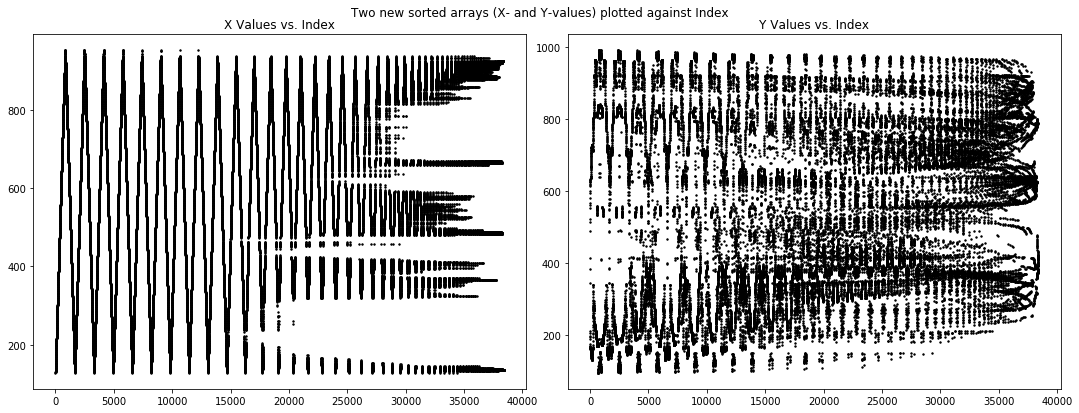

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new sorted arrays (X- and Y-values) plotted against Index")

ax1.scatter(new_df['index'],new_df['x_vals'],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(new_df['index'],new_df['y_vals'],s=2,color='k')
ax2.set_title("Y Values vs. Index")

Text(0.5,1,'Y Values vs. Index')

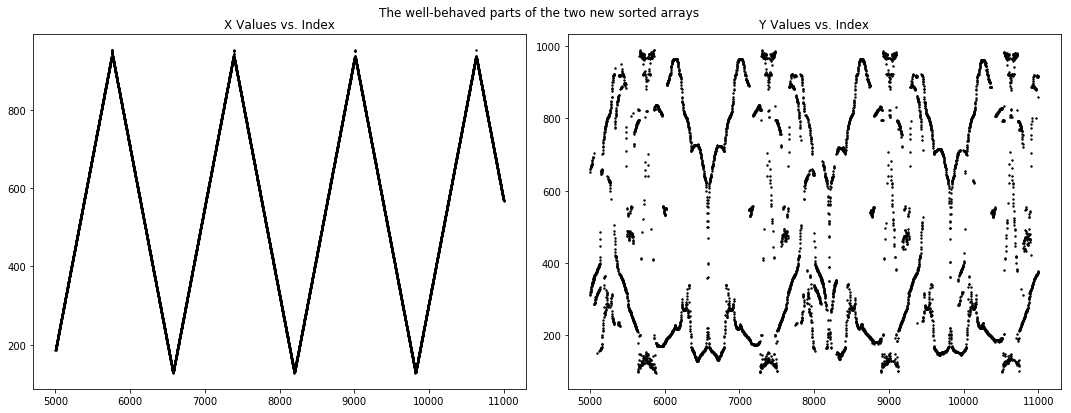

In [53]:
xy_array = np.array(new_df)
small_array = xy_array[5000:11000]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("The well-behaved parts of the two new sorted arrays")

ax1.scatter(small_array[:,0],small_array[:,1],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(small_array[:,0],small_array[:,2],s=2,color='k')
ax2.set_title("Y Values vs. Index")

Ok! You need to make the y-adding part of the algorithm contingent on the x-values at the next step. I.e. only add y-values if there is a corresponding continuous x-value at the next step, otherwise stay the same, otherwise go in the opposite direction, otherwise add the next higher x/y pair if there is no continuous one.

The "X Values" plot isn't actually storing any information - all the information is in the Y-Values plot. Doing the above would allow both plots to convey information. 

In [56]:
def init_wave(input_array):
    val_array = np.copy(input_array)
    new_val_order = []
    
    xmin = np.min(val_array[:,1])
    xmax = np.max(val_array[:,1])
    
    #Choosing random starting points: minimum x, minimum y, random choice within that
    start_array = val_array[val_array[:,1] == xmin]
    ymin = np.min(start_array[:,2])
    start_array = start_array[start_array[:,2] == ymin]
    start_points = start_array[np.random.randint(len(start_array))]
    val_array = val_array[val_array[:,0] != start_points[0]] #Remove the (random) starting value from val_array
    new_val_order.append(start_points)
    
    prev_val = new_val_order[-1]
    prev_val_1 = prev_val[1]
    prev_val_2 = prev_val[2]
    filtered_array_1 = val_array[(val_array[:,1] >= prev_val_1)]
    new_xmin_1 = np.min(filtered_array_1[:,1])
    
    filtered_array_2 = val_array[(val_array[:,1] > prev_val_1)]
    new_xmin_2 = np.min(filtered_array_2[:,1])
    filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmin_1)]
    filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmin_2)]
    
    y_index_1 = np.argmin(filtered_array_1[:,2] - prev_val_2)
    y_opt_1 = filtered_array_1[:,2][y_index_1]
    y_index_2 = np.argmin(filtered_array_2[:,2] - prev_val_2)
    y_opt_2 = filtered_array_2[:,2][y_index_2]
    
    #Go with the y_opt that minimizes the difference with the previous y
    if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
        next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
        next_points = next_array[np.random.randint(len(next_array))] #Get the next points
        new_val_order.append(next_points) #Append the next points to the new array
        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    else:
        next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
        next_points = next_array[np.random.randint(len(next_array))] #Get the next points
        new_val_order.append(next_points) #Append the next points to the new array
        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    
    return val_array,new_val_order

The below function - "first few vals" - should be the basis for whatever function you write. It gets the values nice and orderly. 

In [57]:
def first_few_vals(input_array,iters=20): #used to be 10
    val_array,val_order = init_wave(input_array)
    
    new_val_order = []
    for i in val_order:
        new_val_order.append(i)
    
    for i in range(iters):
        xmin = np.min(val_array[:,1])
        xmax = np.max(val_array[:,1])

        #Initialize
        prev_vals = new_val_order[-1]
        
        prev_val_1 = prev_vals[1]
        prev_val_2 = prev_vals[2]
        
        if xmax>prev_val_1:
            filtered_array_1 = val_array[(val_array[:,1] >= prev_val_1)]
            filtered_array_2 = val_array[(val_array[:,1] > prev_val_1)]
            
            new_xmin_2 = np.min(filtered_array_2[:,1])
            new_xmin_1 = np.min(filtered_array_1[:,1])

            filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmin_1)]
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmin_2)]
            
            #This makes sure that the added y's move in an upward direction
            filtered_array_1 = filtered_array_1[(filtered_array_1[:,2]>= prev_val_2)]
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,2]>= prev_val_2)]
                       
            y_index_1 = np.argmin(filtered_array_1[:,2] - prev_val_2)
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            
            y_index_2 = np.argmin(filtered_array_2[:,2] - prev_val_2)
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                
        else: #This section doesn't work ideally - but it doesn't really matter since this is just for the first points
            filtered_array_1 = val_array[(val_array[:,1] == xmax)]    
            y_index_1 = np.argmin(filtered_array_1[:,2] - prev_val_2)
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
            next_points = next_array[np.random.randint(len(next_array))] #Get the next points
            new_val_order.append(next_points) #Append the next points to the new array
            val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    val_array = np.array(val_array)
    new_val_order = np.array(new_val_order)
    
    return val_array,new_val_order

In [58]:
def return_neibs(new_val_order,neibs = 2): ###used to be 5
    prev_x_vals = []
    prev_y_vals = []
    for i in range(1,neibs+1):
        prev_val = new_val_order[-i]
        prev_val_x = prev_val[1]
        prev_val_y = prev_val[2]
        
        prev_x_vals.append(prev_val_x)
        prev_y_vals.append(prev_val_y)
    
    return prev_x_vals,prev_y_vals

#def going_up(previous_neibs):
    

In [59]:
def going_up(prev_vals):
    diffs = []
    for i in range(len(prev_vals)-1):
        diff = prev_vals[i] - prev_vals[i+1]
        diffs.append(diff)
    diff_sum = np.sum(diffs)
    return diff_sum

The below could obviously be broken up into smaller pieces. If you have the time tomorrow, you should do so, so that it is more comprehensible to others. 

In [60]:
#Rewrite these so that they return 2 arrays - one at the same, one at the next highest
def going_up_x_step(val_array,prev_val_1):
    filtered_array_1 = val_array[(val_array[:,1] >= prev_val_1)]
    filtered_array_2 = val_array[(val_array[:,1] > prev_val_1)]

    new_xmin_1 = np.min(filtered_array_1[:,1])
    new_xmin_2 = np.min(filtered_array_2[:,1])

    filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmin_1)]
    filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmin_2)]
    
    return filtered_array_1,filtered_array_2

def going_down_x_step(val_array,prev_val_1):
    filtered_array_1 = val_array[(val_array[:,1] <= prev_val_1)]
    filtered_array_2 = val_array[(val_array[:,1] < prev_val_1)]
    
    new_xmax_1 = np.max(filtered_array_1[:,1])
    new_xmax_2 = np.max(filtered_array_2[:,1])    
    
    filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmax_1)]
    filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmax_2)]
    
    return filtered_array_1, filtered_array_2

In [61]:
def default_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,val_array):
    
    if len(filtered_array_1)>0:
        if len(filtered_array_2)>0:

            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_index_2 = np.argmin(np.abs(filtered_array_2[:,2] - prev_val_2))

            y_opt_1 = filtered_array_1[:,2][y_index_1]
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        
        else:
            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
            next_points = next_array[np.random.randint(len(next_array))] #Get the next points
            new_val_order.append(next_points) #Append the next points to the new array
            val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    
    return new_val_order,val_array

In [62]:
def going_down_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array):
    
    old_filtered_array_1 = np.copy(filtered_array_1)
    old_filtered_array_2 = np.copy(filtered_array_2)
    
    filtered_array_1 = filtered_array_1[filtered_array_1[:,2] <= prev_val_2]
    filtered_array_2 = filtered_array_2[filtered_array_2[:,2] < prev_val_2]
    
    if len(filtered_array_1)>0:
        if len(filtered_array_2)>0:
            
            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            
            y_index_2 = np.argmin(np.abs(filtered_array_2[:,2] - prev_val_2))
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        else:
            new_ymax = np.max(filtered_array_1[:,2])
            filtered_array_1 = filtered_array_1[(filtered_array_1[:,2]==new_ymax)]
            next_points = filtered_array_1[np.random.randint(len(filtered_array_1))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    else:
        if len(filtered_array_2)>0:
            new_ymax = np.max(filtered_array_2[:,2])
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,2]==new_ymax)]
            next_points = filtered_array_2[np.random.randint(len(filtered_array_2))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    
        else:
            new_val_order,val_array = default_y_step(old_filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,val_array)
    
    return new_val_order,val_array

In [63]:
def going_up_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array):
    
    old_filtered_array_1 = np.copy(filtered_array_1)
    old_filtered_array_2 = np.copy(filtered_array_2)
    
    filtered_array_1 = filtered_array_1[filtered_array_1[:,2] >= prev_val_2]
    filtered_array_2 = filtered_array_2[filtered_array_2[:,2] > prev_val_2]
    
    if len(filtered_array_1)>0:
        if len(filtered_array_2)>0:
            
            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            
            y_index_2 = np.argmin(np.abs(filtered_array_2[:,2] - prev_val_2))
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        else:
            new_ymin = np.min(filtered_array_1[:,2])
            filtered_array_1 = filtered_array_1[(filtered_array_1[:,2]==new_ymin)]
            next_points = filtered_array_1[np.random.randint(len(filtered_array_1))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    else:
        if len(filtered_array_2)>0:
            new_ymin = np.min(filtered_array_2[:,2])
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,2]==new_ymin)]
            next_points = filtered_array_2[np.random.randint(len(filtered_array_2))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    
        else:
            new_val_order,val_array = default_y_step(old_filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,val_array)
    
    return new_val_order,val_array

In [64]:
def y_step_sequence(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array,y_min,y_max,prev_vals_y):
    
    #If the array recently hit y_max, we should force it to go down
    if y_max in prev_vals_y: 
        new_val_order,val_array = going_down_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
            
    #If the array recently hit y_min, force it to go up
    elif y_min in prev_vals_y: 
        new_val_order,val_array = going_up_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
           
    #If it's going up and less than y-max, tell it to keep going up
    elif going_up(prev_vals_y)>0:
        new_val_order,val_array = going_up_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
           
    #If it's going down and greater than y-min, tell it to keep going down
    elif going_up(prev_vals_y)<=0: 
        new_val_order,val_array = going_down_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array) 
        
    return new_val_order,val_array
             

In [65]:
def initialize_step(val_array,new_val_order):
    x_max = np.max(val_array[:,1])
    x_min = np.min(val_array[:,1])
    y_max = np.max(val_array[:,2])
    y_min = np.min(val_array[:,2])
        
    prev_vals_x,prev_vals_y = return_neibs(new_val_order)
    prev_val_1 = prev_vals_x[0]
    prev_val_2 = prev_vals_y[0]
    
    return x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2
    

In [68]:
def double_wave_form(input_array):
    val_array,start_points = first_few_vals(input_array,iters=10)
    
    new_val_order = []
    for i in start_points:
        new_val_order.append(i)
    
    while len(val_array)>0:
        x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2 = initialize_step(val_array,new_val_order)
        
        while x_max > prev_val_1 and len(val_array)>0:
            filtered_array_1,filtered_array_2 = going_up_x_step(val_array,prev_val_1)
            new_val_order,val_array = y_step_sequence(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array,y_min,y_max,prev_vals_y)   
            x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2 = initialize_step(val_array,new_val_order)
           
            #if prev_val_1 == x_max:
            if x_max in prev_vals_x: #Change the above so that it goes down if x_max in previous few x_vals
                while x_min < prev_val_1 and len(val_array)>0:
                    filtered_array_1,filtered_array_2 = going_down_x_step(val_array,prev_val_1)
                    new_val_order,val_array = y_step_sequence(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array,y_min,y_max,prev_vals_y)
                    
                    if len(val_array)>0: ###
                        x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2 = initialize_step(val_array,new_val_order)

        #For now, let's just add the remaining values to the array
        for i in val_array:
            new_val_order.append(i)
            val_array = val_array[val_array[:,0] != i[0]] #Remove the item from val array
            
    x_vals = []
    y_vals = []
    new_index = []
    j = 0
    for i in new_val_order:
        x_vals.append(i[1])
        y_vals.append(i[2])
        new_index.append(j)
        j += 1
        
    #And let's stitch this all up into a single dataframe
    new_df = pd.DataFrame({
        'index':new_index,
        'x_vals':x_vals,
        'y_vals':y_vals})
            
    return new_df,x_vals,y_vals

In [69]:
sorted_df, sorted_x, sorted_y = double_wave_form(val_array)
len(sorted_df)

38167

Text(0.5,1,'Y Values vs. Index')

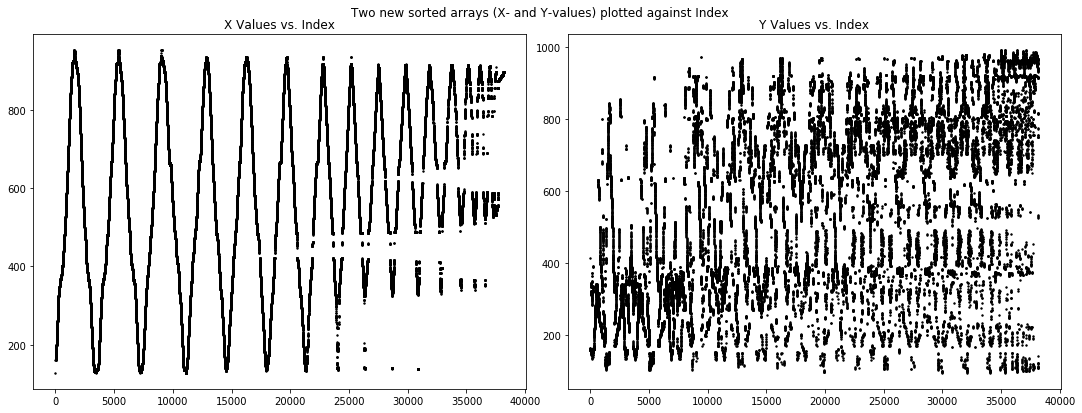

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new sorted arrays (X- and Y-values) plotted against Index")

ax1.scatter(sorted_df['index'],sorted_df['x_vals'],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(sorted_df['index'],sorted_df['y_vals'],s=2,color='k')
ax2.set_title("Y Values vs. Index")

Text(0.5,1,'Y Values vs. Index')

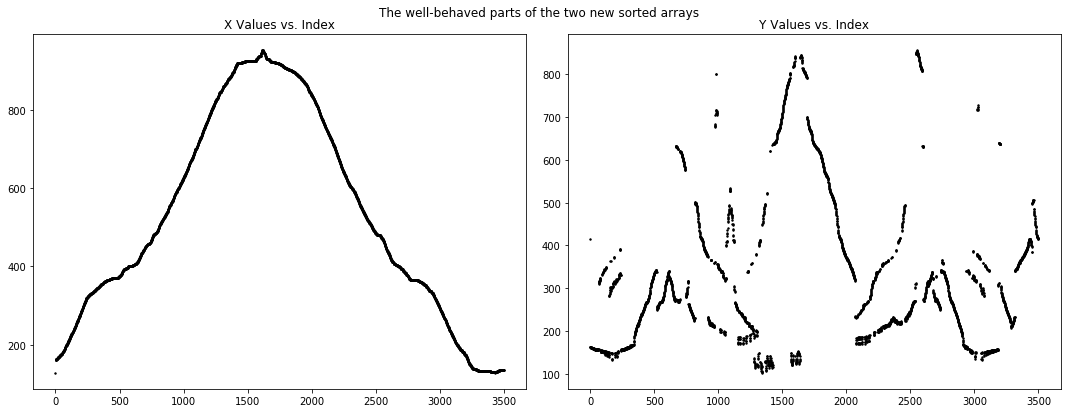

In [321]:
xy_array = np.array(sorted_df)
small_array = xy_array[0:3500]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("The well-behaved parts of the two new sorted arrays")

ax1.scatter(small_array[:,0],small_array[:,1],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(small_array[:,0],small_array[:,2],s=2,color='k')
ax2.set_title("Y Values vs. Index")

As we can see, this new approach seems to isolate various fairly-continuous segments from the array of y-values. This is potentially something that could be approximated with a set of interpolating functions. 

What it seems like is the y-function could be well-approximated by a series of overlapping functions. What we could do is: string together values that are close together in both index- and y-value together, and then plot them. 

In [223]:
short_array = xy_array[2000:3000]
len(short_array)

1000

In [335]:
def euc_dist(v1,v2):
    v1_x = v1[0]
    v2_x = v2[0]
    
    v1_y = v1[2]
    v2_y = v2[2]
    
    x_delta = np.abs(v1_x - v2_x)
    y_delta = np.abs(v1_y - v2_y)
    
    z_delta = np.sqrt(x_delta**2 + y_delta**2)
    
    return z_delta
    

In [386]:
def create_clusters(input_array,thresh_distance=20):
    
    starting_val = input_array[0]
    clusters = []
    clusters.append([starting_val])

    for i in input_array:
        if euc_dist(i,clusters[-1][-1]) < thresh_distance:
            clusters[-1].append(i)
            
        elif len(clusters)>1 and euc_dist(i,clusters[-2][-1]) < thresh_distance:
            clusters[-2].append(i)     
        
        elif len(clusters)>2 and euc_dist(i,clusters[-3][-1]) < thresh_distance:
            clusters[-3].append(i) 
        
        else:
            clusters.append([i])
    
    clusters_list = []
    for i in clusters:
        clusters_list.append(np.array(i))

    return clusters_list

In [387]:
clusters_list = create_clusters(xy_array)

lens_list = [len(i) for i in clusters_list]

(0, 50)

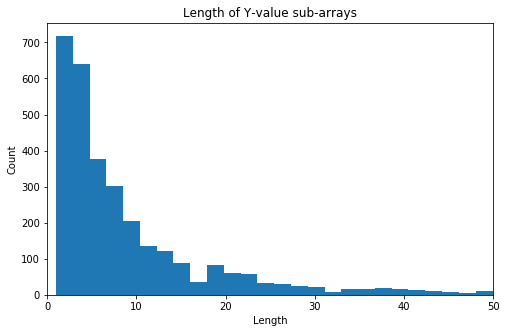

In [388]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(lens_list,bins=200)
ax.set_xlabel('Length')
ax.set_ylabel('Count')
ax.set_title('Length of Y-value sub-arrays')
ax.set_xlim([0,50])

In [466]:
def plot_cluster(clusters_list,number):
    plt.scatter(clusters_list[number][:,0],clusters_list[number][:,2],s=2,color='k')
    #plt.show()

In [467]:
long_clusters = []

for i in clusters_list:
    if len(i)>50:
        long_clusters.append(i)

len(long_clusters)

123

In [468]:
short_clusters = long_clusters[0:80]
len(short_clusters)

80

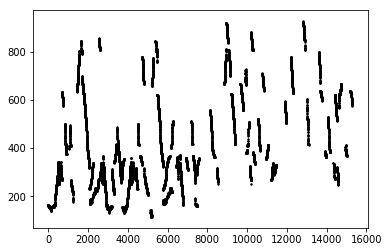

In [469]:
for i in range(len(short_clusters)):
    plot_cluster(short_clusters,i)
    
plt.show()

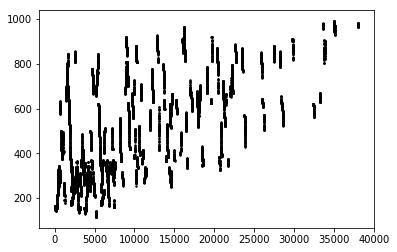

In [470]:
for i in range(len(long_clusters)):
    plot_cluster(long_clusters,i)
    
plt.show()

In [441]:
new_ind_vals = []
new_x_vals = []
new_y_vals = []

for i in long_clusters:
    for j in i:
        new_ind_vals.append(j[0])
        new_x_vals.append(j[1])
        new_y_vals.append(j[2])

simple_df = pd.DataFrame({
    'index':new_ind_vals,
    'X_Vals': new_x_vals,
    'Y_Vals': new_y_vals})
        

Text(0.5,1,'Simplified Arrays plotted against one another')

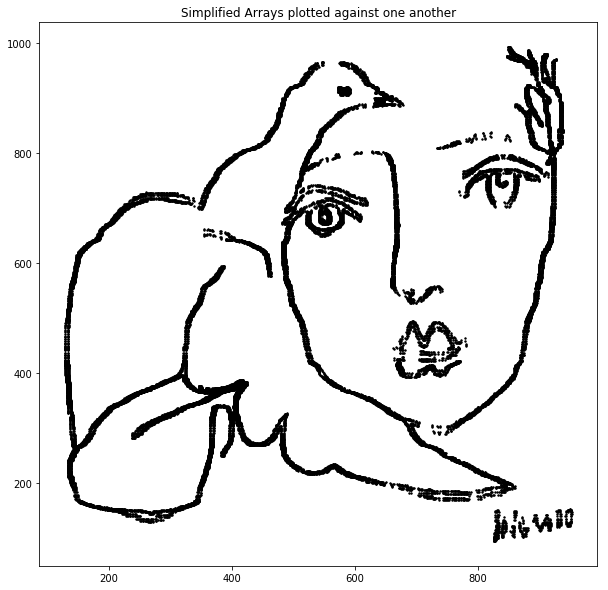

In [442]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(simple_df['X_Vals'],simple_df['Y_Vals'],s=2,color='k')
ax.set_title("Simplified Arrays plotted against one another")

Next step: Interpolate each segment, and then graph these two things with respect to one another. 

In [378]:
euc_dist(long_clusters[1][4],long_clusters[1][5])

1.4142135623730951

In [427]:
ind_vals,x_vals,y_vals = index_value_split(long_clusters)

In [426]:
def index_value_split(cluster_array):
    index_vals = []
    x_vals = []
    y_vals = []
    for i in cluster_array:
        index_vals.append(i[:,0])
        x_vals.append(i[:,1])
        y_vals.append(i[:,2])
    
    return index_vals,x_vals,y_vals
        

In [420]:
def gen_interp_funs(index_arrays,sub_arrays):
    interp_funs = [] #This will be an array of separate interpolation functions
    for i in range(len(sub_arrays)):
        f_i = interp1d(index_arrays[i], sub_arrays[i], kind='cubic',fill_value="extrapolate")
        interp_funs.append(f_i)
    
    return interp_funs

In [421]:
def gen_interp_vals(interp_funs,index_arrays):
    calc_vals = []
    for i in range(len(index_arrays)):
        fun_iter = interp_funs[i]
        calc_val_list = [fun_iter(index_arrays[i])]
        calc_vals.append(calc_val_list)

    #Now let's stitch this all up into a single array
    calc_val_array = []
    for i in calc_vals:
        for j in i[0]:
            calc_val_array.append(j)

    index_val_array = []
    for i in index_arrays:
        for j in i:
            index_val_array.append(j)
    
    return index_val_array,calc_val_array

Text(0.5,1,'Calculated Y Values vs. Index')

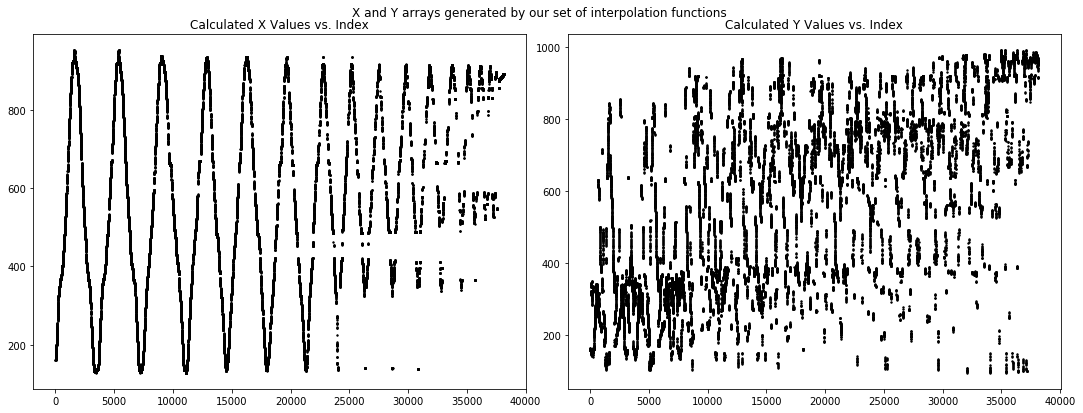

In [473]:
interp_funs_x = gen_interp_funs(ind_vals,x_vals)
index_val_array,calc_val_array_x = gen_interp_vals(interp_funs_x,ind_vals)

interp_funs_y = gen_interp_funs(ind_vals,y_vals)
index_val_array,calc_val_array_y = gen_interp_vals(interp_funs_y,ind_vals)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("X and Y arrays generated by our set of interpolation functions")

ax1.scatter(index_val_array,calc_val_array_x,s=2,color='k')
ax1.set_title("Calculated X Values vs. Index")
ax2.scatter(index_val_array,calc_val_array_y,s=2,color='k')
ax2.set_title("Calculated Y Values vs. Index")

Text(0.5,1,'Interpolant-generated arrays plotted against one another')

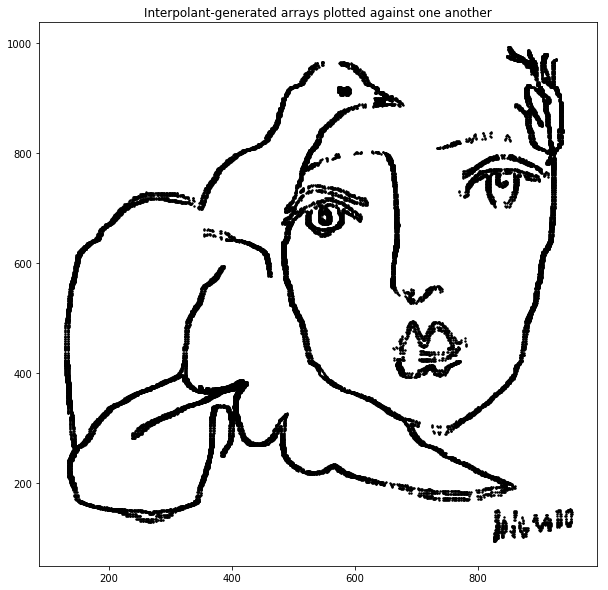

In [475]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(calc_val_array_x,calc_val_array_y,s=2,color='k')
ax.set_title("Interpolant-generated arrays plotted against one another")

In [1]:
x_vals.shape

NameError: name 'x_vals' is not defined